In [4]:
import pandas as pd
import numpy as np
import pandas as pd
from haversine import haversine, Unit
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix


In [5]:
df = pd.read_csv("/workspaces/Emiliano0041-IntroML/data/raw/medical_insurance_cost.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
df["sex_n"] = pd.factorize(df["sex"])[0]
df["smoker_n"] = pd.factorize(df["smoker"])[0]
df["region_n"] = pd.factorize(df["region"])[0]
df.head()

,age,sex,bmi,children,smoker,region,charges,sex_n,smoker_n,region_n
0,19,female,27.900,0,yes,southwest,16884.92400,0,0,0
1,18,male,33.770,1,no,southeast,1725.55230,1,1,1
2,28,male,33.000,3,no,southeast,4449.46200,1,1,1
3,33,male,22.705,0,no,northwest,21984.47061,1,1,2
4,32,male,28.880,0,no,northwest,3866.85520,1,1,2


In [8]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
sex_n       0
smoker_n    0
region_n    0
dtype: int64

<Axes: >

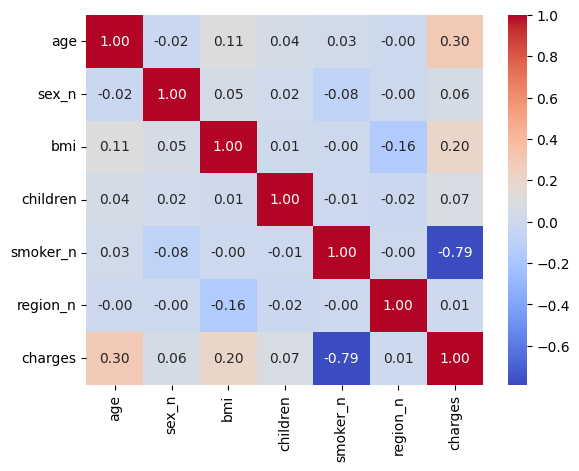

In [9]:
sns.heatmap(df[["age", "sex_n", "bmi", "children", "smoker_n", "region_n", "charges"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")

> Conclusiones

- Podemos notar las altas correlaciones de las variables "age", "bmi" y "smoker_n"(con mucha importancia) con la variable objetivo "charges"

[Text(0, 0.5, '')]

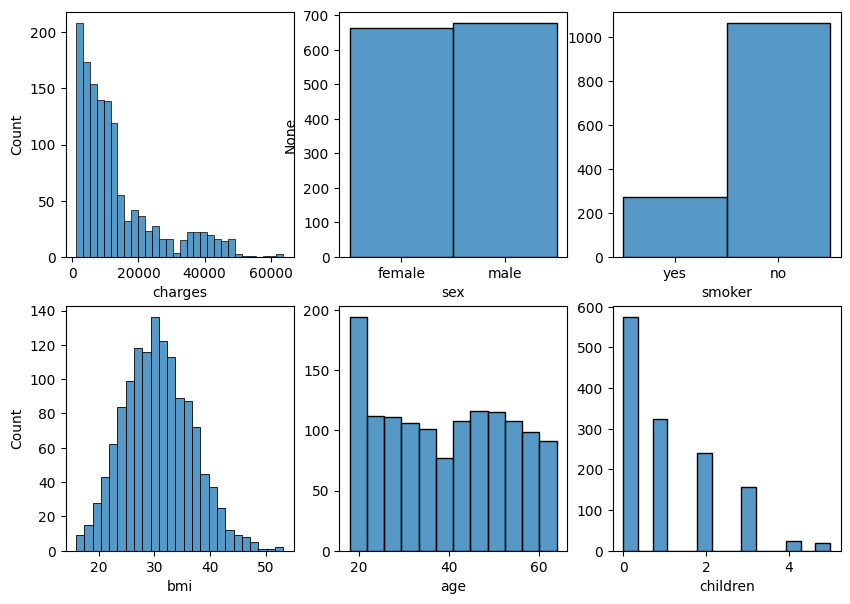

In [10]:
fig, axis = plt.subplots(2, 3, figsize = (10, 7))


sns.histplot(ax=axis[0, 0], data=df, x="charges")
sns.histplot(ax=axis[0, 1], data=df, x="sex").set(ylabel="None")
sns.histplot(ax=axis[0, 2], data=df, x="smoker").set(ylabel=None)
sns.histplot(ax=axis[1, 0], data=df, x="bmi")
sns.histplot(ax=axis[1, 1], data=df, x="age").set(ylabel=None)
sns.histplot(ax=axis[1, 2], data=df, x="children").set(ylabel=None)


- En el primer grafico podemos analizar que la mayoria de los cargos estan entre 0 y 20000.

- En el segundo podemos observar que los datos tienen muestras casi por igual cantidad de hombres y mujeres, siendo levemente superior la cantudad en hombres.

- Podemos tambien observar que las personas que no fuman superan ampliamente a las fumadoras.

- Encontramos que en el grafico de "bmi" (Indice de masa corporal") hay una similitud con una campana de Gauss, o de distribucion normal.

- En la edad encontramos que hay una leve mayoria en personas de 20 años aproximadamente, y luego se mantiene en estandares similares.

- En el ultimo grafico podemos observar que casi la mitad de las personas no tenian hijos.

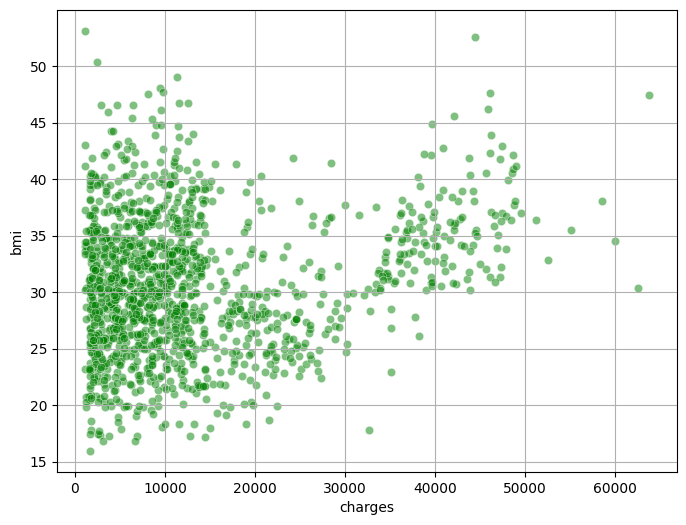

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(df, x="charges", y="bmi", color="g", alpha=0.5)
plt.grid(True)


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801
sex_n,1338.0,0.505232,0.500160,0.0000,0.00000,1.000,1.000000,1.00000
smoker_n,1338.0,0.795217,0.403694,0.0000,1.00000,1.000,1.000000,1.00000
region_n,1338.0,1.484305,1.104885,0.0000,1.00000,1.000,2.000000,3.00000


In [13]:
df.drop(["sex_n", "smoker_n", "region_n"], axis=1, inplace=True)


> Split

In [14]:
variables = ["age", "sex", "bmi", "children", "smoker", "region"]

X = df.drop("charges", axis=1)[variables]
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)



> Encoder

In [15]:
var_cat = ["sex", "smoker", "region"]

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Entrenamos al encoder
encoder.fit(X_train[var_cat])

# Aplicamos el encoder al conjunto de entrenamiento
X_train_ohe = encoder.transform(X_train[var_cat])
X_train_ohe = pd.DataFrame(X_train_ohe,
                           index=X_train.index,
                           columns=encoder.get_feature_names_out(var_cat))

# Aplicamos el encoder al conjunto de test
X_test_ohe = encoder.transform(X_test[var_cat])
X_test_ohe = pd.DataFrame(X_test_ohe,
                          index=X_test.index,
                          columns=encoder.get_feature_names_out(var_cat))


> Concatenacion de las X_train y X_test

In [16]:
X_train_num = X_train.drop(columns=var_cat)
X_test_num = X_test.drop(columns=var_cat)

X_train_final = pd.concat([X_train_num, X_train_ohe], axis=1)
X_test_final = pd.concat([X_test_num, X_test_ohe], axis=1)

> Escalado

In [17]:
scaler = StandardScaler()
scaler.fit(X_train_final)

X_train_norm = scaler.transform(X_train_final)
X_train_norm = pd.DataFrame(X_train_norm, index = X_train_final.index, columns=X_train_final.columns)

X_test_norm = scaler.transform(X_test_final)
X_test_norm = pd.DataFrame(X_test_norm, index=X_test_final.index, columns=X_test_final.columns)


> Selector

In [18]:
selector = SelectKBest(score_func=f_regression).fit(X_train_norm, y_train)
selected_cols = X_train_norm.columns[selector.get_support()]

X_train_sel = pd.DataFrame(selector.transform(X_train_norm), columns=selected_cols)
X_test_sel = pd.DataFrame(selector.transform(X_test_norm), columns=selected_cols)

X_train_sel.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northwest,region_southeast,region_southwest
0,0.472227,-1.756525,0.734336,1.024602,-1.024602,0.508747,-0.508747,1.783168,-0.599661,-0.572314
1,0.543313,-1.033082,-0.911192,1.024602,-1.024602,0.508747,-0.508747,-0.560800,-0.599661,-0.572314
2,0.898745,-0.943687,-0.911192,1.024602,-1.024602,0.508747,-0.508747,-0.560800,1.667609,-0.572314
3,-0.025379,0.622393,3.202629,1.024602,-1.024602,0.508747,-0.508747,-0.560800,1.667609,-0.572314
4,1.040918,-1.504893,1.557100,1.024602,-1.024602,0.508747,-0.508747,1.783168,-0.599661,-0.572314


> Creacion del modelo 

In [19]:
model = LinearRegression()
model.fit(X_train_sel, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


> Extrayendo los parametros del modelo lineal

In [20]:

intercept = model.intercept_
coefficient = model.coef_[0]

intercept, coefficient


(np.float64(13346.089736364485), np.float64(3614.9754148279917))

> Calculamos el coeficiente de Determinacion (R2)

- Evaluamos el desempeño del modelo

In [21]:
model.score(X_train_sel, y_train)

0.7417255854683333

> Guardamos todos los datos de procesamiento junto con el modelo


In [22]:
scaler_ = {"scaler" : scaler}
select_ = {"selector" : selector}
train = {"X_train" : X_train_final,
         "y_train" : y_train}
test ={"X_test" : X_test_final,
       "y_test" : y_test}
modelo = {"modelo" : model}

ruta = "/workspaces/Emiliano0041-IntroML/data/processed/"

with open(ruta + "scaler02.pkl", "wb") as f:
    pickle.dump(scaler_,f)

with open(ruta + "select02.pkl", "wb") as f:
    pickle.dump(select_, f)

with open(ruta + "train02.pkl", "wb") as f:
    pickle.dump(train, f)

with open(ruta + "test02", "wb") as f:
    pickle.dump(test, f)

with open(ruta + "modelo02", "wb") as f:
    pickle.dump(modelo, f)